# 1. Importing libraries
Import the libraries required for DANN (Domain-Adversarial Neural Networks)

In [1]:
import os
import gzip
import time
import pickle
import datetime
import requests
import warnings

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from easydict import EasyDict
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.autograd import Function
from torchvision import datasets, transforms

warnings.filterwarnings(action='ignore')

# 2. Setting parameters


In [2]:
cfg = EasyDict()

# Parameters for datasets
cfg.dataset = EasyDict()
cfg.dataset.root = './data'
cfg.dataset.img_size = 28
cfg.dataset.batch_size = 32

# Parameters for model architecture
cfg.model = EasyDict()
cfg.model.extractor = EasyDict()
cfg.model.extractor.in_channels = 3

cfg.model.classifier = EasyDict()
cfg.model.classifier.in_features = 768
cfg.model.classifier.out_features = 10

cfg.model.discriminator = EasyDict()
cfg.model.discriminator.in_features = 768
cfg.model.discriminator.out_features = 2

# Parameters for training
cfg.train = EasyDict()
cfg.train.epoch = 50

cfg.train.optim = EasyDict()
cfg.train.optim.initial_lr = 0.01
cfg.train.optim.alpha = 10
cfg.train.optim.beta = 0.75
cfg.train.optim.gamma = 10
cfg.train.optim.momentum = 0.9

# Parameters for outputs
cfg.out = EasyDict()
cfg.out.save = './save'
cfg.out.visual_root = './visuals'

# 3. Loading the MNIST dataset

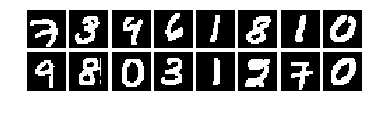

 - **Images:** Handwritten digits
 - **Categories:** 0 ~ 9
 - **Shape of Image:** 1 X 28 X 28
 - **Number of training set:** 60,000
 - **Number of test set** : 10,000

In [3]:
def get_mnist(cfg, train=True):
    """ Get the MNIST data loader """

    # Image pre-processing
    transform = transforms.Compose([transforms.Resize(cfg.dataset.img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,)),
                                    transforms.Lambda(lambda x: x.repeat(3, 1, 1))])

    # MNIST dataset
    mnist = datasets.MNIST(root=cfg.dataset.root,
                           train=train,
                           download=True,
                           transform=transform)

    # MNIST data loader
    mnist_loader = data.DataLoader(dataset=mnist,
                                   batch_size=cfg.dataset.batch_size,
                                   shuffle=True)

    return mnist_loader


mnist = get_mnist(cfg, train=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 110379948.08it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24878967.72it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26958545.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20440481.51it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



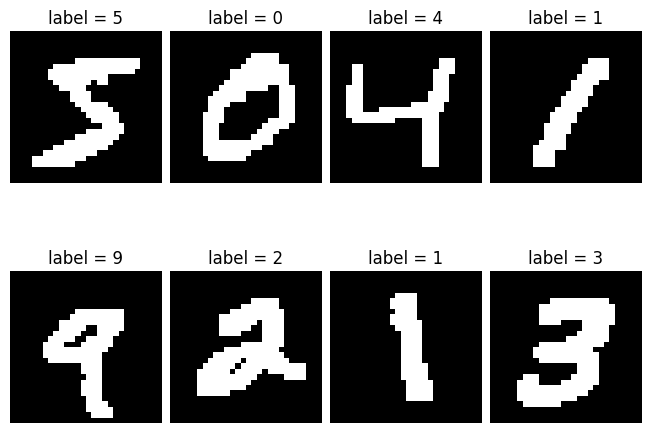

In [4]:
fig, axes = plt.subplots(2, 4, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    ax.imshow(mnist.dataset.data[i], cmap='gray', vmin=0, vmax=1)
    ax.set(title='label = {}'.format(mnist.dataset.train_labels[i]))
    ax.set_axis_off()

# 4. Loading the MNIST-M Dataset

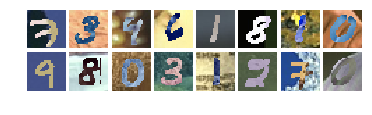

 - **Images:** MNIST digits + BSDS500(randomly extracted as background)
 - **Categories:** 0 ~ 9
 - **Shape of Image:** 3 X 28 X 28
 - **Number of training set:** 60,000
 - **Number of test set:** 10,000

In [5]:
class MNISTM(data.Dataset):
    """ The MNIST-M dataset class """

    url = 'https://github.com/VanushVaswani/keras_mnistm/releases/download/1.0/keras_mnistm.pkl.gz'

    def __init__(self, root, train=True, download=False, transform=None):

        super(MNISTM, self).__init__()
        self.root = root
        self.data_dir = 'MNISTM'
        self.raw_dir = 'raw'
        self.train = train
        self.transform = transform

        if download:
            self.download()

    def __getitem__(self, index):
        """ Get images and target for data loader """

        if self.train:
            image, target = self.train_images[index], self.train_labels[index]
        else:
            image, target = self.test_images[index], self.test_labels[index]

        image = Image.fromarray(image.squeeze().numpy(), mode='RGB')

        # Pre-processing
        if self.transform is not None:
            image = self.transform(image)

        return image, target

    def __len__(self):
        """ Return size of dataset """

        if self.train:
            return len(self.train_images)
        else:
            return len(self.test_images)

    def download(self):
        """ Download the MNIST-M data """

        # Make data directory
        os.makedirs(os.path.join(self.root, self.data_dir, self.raw_dir), exist_ok=True)

        # Download the pkl file
        filename = self.url.split('/')[-1]
        filepath = os.path.join(self.root, self.data_dir, self.raw_dir, filename)

        if not os.path.exists(filepath):
            print('Downloading {}'.format(self.url))

            response = requests.get(self.url)
            open(filepath, 'wb').write(response.content)

            # Extract pkl file from gz file
            with open(filepath.replace('.gz', ''), 'wb') as f:
                f.write(gzip.open(filepath, 'rb').read())

        # Load MNIST-M images from pkl file
        with open(filepath.replace('.gz', ''), 'rb') as f:
            mnistm_data = pickle.load(f, encoding='bytes')

        self.train_images = torch.ByteTensor(mnistm_data[b'train'])
        self.test_images = torch.ByteTensor(mnistm_data[b'test'])

        # Get MNIST-M labels from MNIST dataset
        self.train_labels = datasets.MNIST(root=self.root,
                                           train=True,
                                           download=True).targets
        self.test_labels = datasets.MNIST(root=self.root,
                                          train=False,
                                          download=True).targets


def get_mnistm(cfg, train=True):
    """ Get the MNIST-M data loader """

    # Image pre-processing
    transform = transforms.Compose([transforms.Resize(cfg.dataset.img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # MNIST-M dataset
    mnistm = MNISTM(root=cfg.dataset.root,
                    train=train,
                    download=True,
                    transform=transform)

    # MNIST-M data loader
    mnistm_loader = data.DataLoader(dataset=mnistm,
                                    batch_size=cfg.dataset.batch_size,
                                    shuffle=True)

    return mnistm_loader


mnistm = get_mnistm(cfg, train=True)

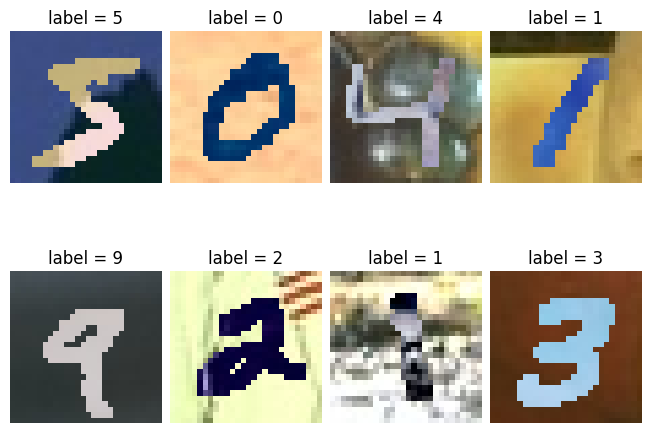

In [6]:
fig, axes = plt.subplots(2, 4, constrained_layout=True)

for i, ax in enumerate(axes.flat):
    ax.imshow(mnistm.dataset.train_images[i], vmin=0, vmax=1)
    ax.set(title='label = {}'.format(mnistm.dataset.train_labels[i]))
    ax.set_axis_off()

# 5. Designing the DANN

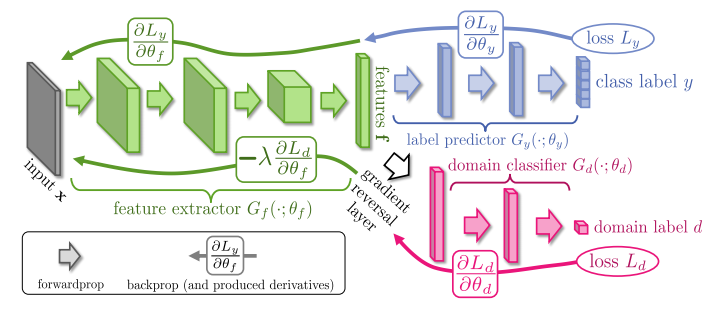

*   **Extractor : Feature extractor (<span style="color:green">green</span>)**<br/>
The feature extractor $G_f$ extracts a feature vector $f$ from an input $x$.<br/>
$f = G_f(x; \theta_f)$ <br/><br/>

*   **Classifier : Label predictor (<span style="color:blue">blue</span>)**<br/>
The Label predictor $G_y$ predicts a label $y$ from a feature vector $f$.<br/>
$y = G_y(f; \theta_y)$ <br/><br/>

*   **Discriminator : Domain classifier (<span style="color:red">red</span>)**<br/>
The domain classifier $G_d$ discriminates a domain label $d$ from a feature vector $f$.<br/>
$d = G_d(f; \theta_d)$ <br/><br/>

*   **ReverseLayerF : Gradient reversal layer(GRL)**<br/>
During the forward propagation, GRL acts as an identity transform.<br/>
During the backpropagation, GRL takes the gradient from the subsequent level, multiplies it by $-\lambda$ and passes it to the preceding layer.<br/>

In [7]:
class ReverseLayerF(Function):
    """ The gradient reverse layer class """

    @staticmethod
    def forward(ctx, x, alpha):
        """ The method for forward propagation """

        ctx.alpha = alpha
        return x

    @staticmethod
    def backward(ctx, grad_output):
        """ The method for backpropagation """

        output = grad_output.neg() * ctx.alpha
        return output, None


class Extractor(nn.Module):
    """ The feature extractor for extracting feature maps  """

    def __init__(self, in_channels):

        super(Extractor, self).__init__()
        self.in_channels = in_channels

        self.extractor = nn.Sequential(
            nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        """ The method for forward propagation """

        x = self.extractor(x)
        x = x.view(x.shape[0], -1)
        return x


class Classifier(nn.Module):
    """ The label predictor for classifying labels """

    def __init__(self, in_features, out_features=10):

        super(Classifier, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=100),
            nn.ReLU(),

            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),

            nn.Linear(in_features=100, out_features=self.out_features)
        )

    def forward(self, x):
        """ The method for forward propagation """

        x = self.classifier(x)
        return x


class Discriminator(nn.Module):
    """ The domain classifier for discriminating domain label """

    def __init__(self, in_features, out_features=2):

        super(Discriminator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.discriminator = nn.Sequential(
            nn.Linear(in_features=self.in_features, out_features=100),
            nn.ReLU(),

            nn.Linear(in_features=100, out_features=self.out_features)
        )

    def forward(self, x, alpha):
        """ The method for forward propagation """

        x = ReverseLayerF.apply(x, alpha)
        x = self.discriminator(x)
        return x

# 6. Utilities

In [8]:
def optimizer_scheduler(optimizer, p, cfg):
    """ Adjust the learning rate of optimizer """

    # Get the parameters for adjusting the learning rate
    initial_lr = cfg.train.optim.initial_lr
    alpha = cfg.train.optim.alpha
    beta = cfg.train.optim.beta

    for param_group in optimizer.param_groups:
        param_group['lr'] = initial_lr / (1. + alpha * p) ** beta

    return optimizer


def save_model(model, filename):
    """ Save the model parameters """

    # Get the directory name
    root = cfg.out.save

    # Make the directory for saving model parameters
    if not os.path.exists(root):
        os.makedirs(root)

    # Save the model parameters
    torch.save(model.state_dict(), os.path.join(root, filename))


def load_model(model, filename):
    """ Load the model parameters """

    # Get the directory name
    root = cfg.out.save
    filepath = os.path.join(root, filename)

    assert os.path.exists(filepath), 'There is no {}.'.format(filepath)

    # Load the model parameters
    model.load_state_dict(torch.load(filepath))

    return model


def _plot_graph(features, labels, domain, filename):
    """ Plot the t-SNE graph """

    # Make the visualization directory
    root = cfg.out.visual_root

    if not os.path.exists(root):
        os.mkdir(root)

    # Rescale the feature range
    feat_max, feat_min = np.max(features, 0), np.min(features, 0)
    features = (features - feat_min) / (feat_max - feat_min)

    # Plotting
    color = {0: 'r', 1: 'b'}

    plt.figure(figsize=(10, 10))
    plt.title(filename.split('.')[0], fontsize=20)

    for i in range(features.shape[0]):
        plt.text(features[i][0], features[i][1],
                 str(labels[i]),
                 color=color[domain[i]],
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig(os.path.join(root, filename))


def visualize(extractor, source_loader, target_loader, filename):
    """ Visualize the data distribution using t-SNE """

    images = []
    labels = []
    domain = []

    # Get some samples from the data loader
    for idx, (src_data, tgt_data) in enumerate(zip(source_loader, target_loader)):
        if idx >= 15:
            break

        images.extend(src_data[0].tolist())
        images.extend(tgt_data[0].tolist())

        labels.extend(src_data[1].tolist())
        labels.extend(tgt_data[1].tolist())

        domain.extend([0] * src_data[0].shape[0])
        domain.extend([1] * tgt_data[0].shape[0])

    # Load a model and images to GPU
    extractor = extractor.cuda()
    images = torch.tensor(images).cuda()

    # Extract the feature maps
    features = extractor(images)

    # Reduce the feature dimensions
    tsne = TSNE(n_components=2, perplexity=30., n_iter=3000, init='pca')
    features = tsne.fit_transform(features.detach().cpu().numpy())

    # Plotting
    _plot_graph(features, labels, domain, filename)

# 7. Training & Test Functions

 - `source_only`: The function that trains a model on the source domain only.
 - `dann`: The function that trains a model on the source and target domains through DANN.
 - `test`: The function that evaluates model performance.


### Losses

* **Loss for label prediction**<br/>
$L_y(G_y(G_f(x_i; \theta_f); \theta_y), y_i)$ <br/><br/>

* **Loss for domain classification** <br/>
$L_d(G_d(G_f(x_i; \theta_f); \theta_d), d_i)$ <br/><br/>

* **Optimization with backpropagation** <br/>
$\theta_f \leftarrow \theta_f - \mu (\frac{\partial L_y^i}{\partial \theta_f} - \lambda \frac{\partial L_d^i}{\partial \theta_f})$ <br/><br/>

In [9]:
def source_only(extractor, classifier, source_loader, cfg):
    """ Train the models using only source dataset """

    # Load the models to GPU
    extractor = extractor.cuda()
    classifier = classifier.cuda()

    # Set up criterion and optimizer
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(params=list(extractor.parameters()) + list(classifier.parameters()),
                          lr=cfg.train.optim.initial_lr,
                          momentum=cfg.train.optim.momentum)

    # Training
    start_time = time.time()
    print('\nSource-Only Training...\n')

    for epoch in range(cfg.train.epoch):
        # Set the model to train mode
        extractor.train()
        classifier.train()

        num_data = 0
        total_acc = 0.0
        total_loss = 0.0

        for idx, (images, labels) in enumerate(source_loader):
            # Update the learning rate
            p = (idx + epoch * len(source_loader)) / cfg.train.epoch / len(source_loader)
            optimizer = optimizer_scheduler(optimizer, p, cfg)

            # Load images and labels to GPU
            images = images.cuda()
            labels = labels.cuda()

            # Predict labels and compute loss
            preds = classifier(extractor(images))
            loss = criterion(preds, labels)

            # Optimize the models
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update total loss and total accuracy
            num_data += len(images)
            total_acc += (preds.max(1)[1] == labels).sum().item()
            total_loss += loss.item()

        total_acc = total_acc / num_data
        total_loss = total_loss / len(source_loader)

        # Print log information
        eta_seconds = ((time.time() - start_time) / (epoch + 1)) * (cfg.train.epoch - (epoch + 1))
        eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
        print('Epoch [{:4}/{:4}] Loss: {:8.4f}, Accuracy: {:6.2f}%, ETA: {}'.format(
            epoch+1, cfg.train.epoch, total_loss, total_acc * 100, eta_string,
        ))

        # Save the model parameters
        if (epoch + 1) % 10 == 0:
            save_model(extractor, 'source_extractor_{}.pt'.format(epoch+1))
            save_model(classifier, 'source_classifier_{}.pt'.format(epoch+1))

    return extractor, classifier


def dann(extractor, classifier, discriminator, source_loader, target_loader, cfg):
    """ Train the models of DANN """

    # Load the models to GPU
    extractor = extractor.cuda()
    classifier = classifier.cuda()
    discriminator = discriminator.cuda()

    # Set up criterion and optimizer
    cls_criterion = nn.CrossEntropyLoss().cuda()
    dis_criterion = nn.CrossEntropyLoss().cuda()

    optimizer = optim.SGD(params=list(extractor.parameters()) +
                                 list(classifier.parameters()) +
                                 list(discriminator.parameters()),
                          lr=cfg.train.optim.initial_lr,
                          momentum=cfg.train.optim.momentum)

    # Training
    start_time = time.time()
    print('\nDANN Training...\n')

    for epoch in range(cfg.train.epoch):
        # Set the model to train mode
        extractor.train()
        classifier.train()
        discriminator.train()

        num_data = 0
        total_acc = 0.0
        total_loss = 0.0
        total_cls_loss = 0.0
        total_dis_loss = 0.0
        len_loader = min(len(source_loader), len(target_loader))

        for idx, (src_data, tgt_data) in enumerate(zip(source_loader, target_loader)):
            src_images, src_labels = src_data
            tgt_images, _ = tgt_data

            # Compute the alpha value and update the learning rate
            p = (idx + epoch * len_loader) / cfg.train.epoch / len_loader
            alpha = 2. / (1. + np.exp(-cfg.train.optim.gamma * p)) - 1
            optimizer = optimizer_scheduler(optimizer, p, cfg)

            # Load images and labels to GPU
            src_images, src_labels = src_images.cuda(), src_labels.cuda()
            tgt_images = tgt_images.cuda()

            # Predict class labels and compute classification loss
            cls_preds = classifier(extractor(src_images))
            cls_loss = cls_criterion(cls_preds, src_labels)

            # Update total classification loss and total classification accuracy
            num_data += len(src_images)
            total_acc += (cls_preds.max(1)[1] == src_labels).sum().item()
            total_cls_loss += cls_loss.item()


            # Make the domain labels
            domain_source_labels = torch.zeros(src_images.shape[0]).type(torch.LongTensor)
            domain_target_labels = torch.ones(tgt_images.shape[0]).type(torch.LongTensor)
            domain_labels = torch.cat([domain_source_labels, domain_target_labels], 0).cuda()
            combined_images = torch.cat([src_images, tgt_images], 0)

            # Predict domain labels and compute discrimination loss
            dis_preds = discriminator(extractor(combined_images), alpha)
            dis_loss = dis_criterion(dis_preds, domain_labels)

            # Update total discrimination loss and total loss
            loss = cls_loss + dis_loss
            total_dis_loss += dis_loss.item()
            total_loss += loss.item()

            # Optimize the models
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_acc = total_acc / num_data
        total_loss = total_loss / len_loader
        total_cls_loss = total_cls_loss / len_loader
        total_dis_loss = total_dis_loss / len_loader

        # Print log information
        eta_seconds = ((time.time() - start_time) / (epoch + 1)) * (cfg.train.epoch - (epoch + 1))
        eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
        print('Epoch [{:4}/{:4}] Loss: {:8.4f}, Class Loss: {:8.4f}, Domain Loss: {:8.4f}, Accuracy: {:6.2f}%, ETA: {}'.format(
            epoch+1, cfg.train.epoch, total_loss, total_cls_loss, total_dis_loss, total_acc * 100, eta_string,
        ))

        # Save the model parameters
        if (epoch + 1) % 10 == 0:
            save_model(extractor, 'dann_extractor_{}.pt'.format(epoch+1))
            save_model(classifier, 'dann_classifier_{}.pt'.format(epoch+1))

    return extractor, classifier


def test(extractor, classifier, data_loader):
    """ Estimate the model performance """

    # Load the models to GPU
    extractor = extractor.cuda()
    classifier = classifier.cuda()

    # Set the model to evaluation mode
    extractor.eval()
    classifier.eval()

    num_data = 0
    total_acc = 0.0

    # Test
    with torch.no_grad():
        for images, labels in data_loader:
            # Load images and labels to GPU
            images = images.cuda()
            labels = labels.cuda()

            # Predict the labels
            preds = classifier(extractor(images))

            # Update the total accuracy
            num_data += len(images)
            total_acc += (preds.max(1)[1] == labels).sum().item()

        total_acc = total_acc / num_data

    print('Test Accuracy: {:.4f}%'.format(total_acc * 100))

# 8. Main Function

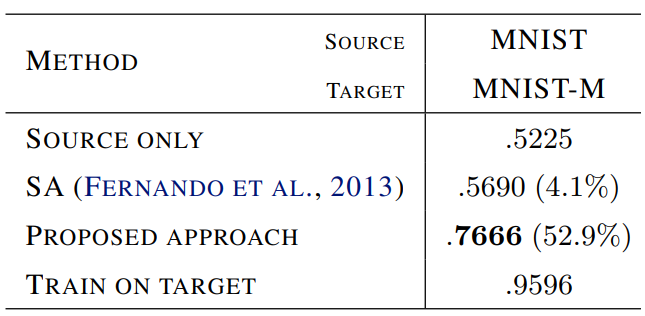

### Source-Only


Source-Only Training...

Epoch [   1/  50] Loss:   0.1690, Accuracy:  94.67%, ETA: 0:17:53
Epoch [   2/  50] Loss:   0.0405, Accuracy:  98.77%, ETA: 0:17:12
Epoch [   3/  50] Loss:   0.0276, Accuracy:  99.16%, ETA: 0:16:34
Epoch [   4/  50] Loss:   0.0185, Accuracy:  99.37%, ETA: 0:16:32
Epoch [   5/  50] Loss:   0.0131, Accuracy:  99.57%, ETA: 0:15:58
Epoch [   6/  50] Loss:   0.0091, Accuracy:  99.73%, ETA: 0:15:34
Epoch [   7/  50] Loss:   0.0054, Accuracy:  99.82%, ETA: 0:15:03
Epoch [   8/  50] Loss:   0.0042, Accuracy:  99.88%, ETA: 0:14:40
Epoch [   9/  50] Loss:   0.0026, Accuracy:  99.93%, ETA: 0:14:14
Epoch [  10/  50] Loss:   0.0018, Accuracy:  99.95%, ETA: 0:13:54
Epoch [  11/  50] Loss:   0.0010, Accuracy:  99.98%, ETA: 0:13:29
Epoch [  12/  50] Loss:   0.0007, Accuracy:  99.98%, ETA: 0:13:07
Epoch [  13/  50] Loss:   0.0006, Accuracy:  99.98%, ETA: 0:12:45
Epoch [  14/  50] Loss:   0.0004, Accuracy:  99.99%, ETA: 0:12:26
Epoch [  15/  50] Loss:   0.0003, Accuracy: 100.00

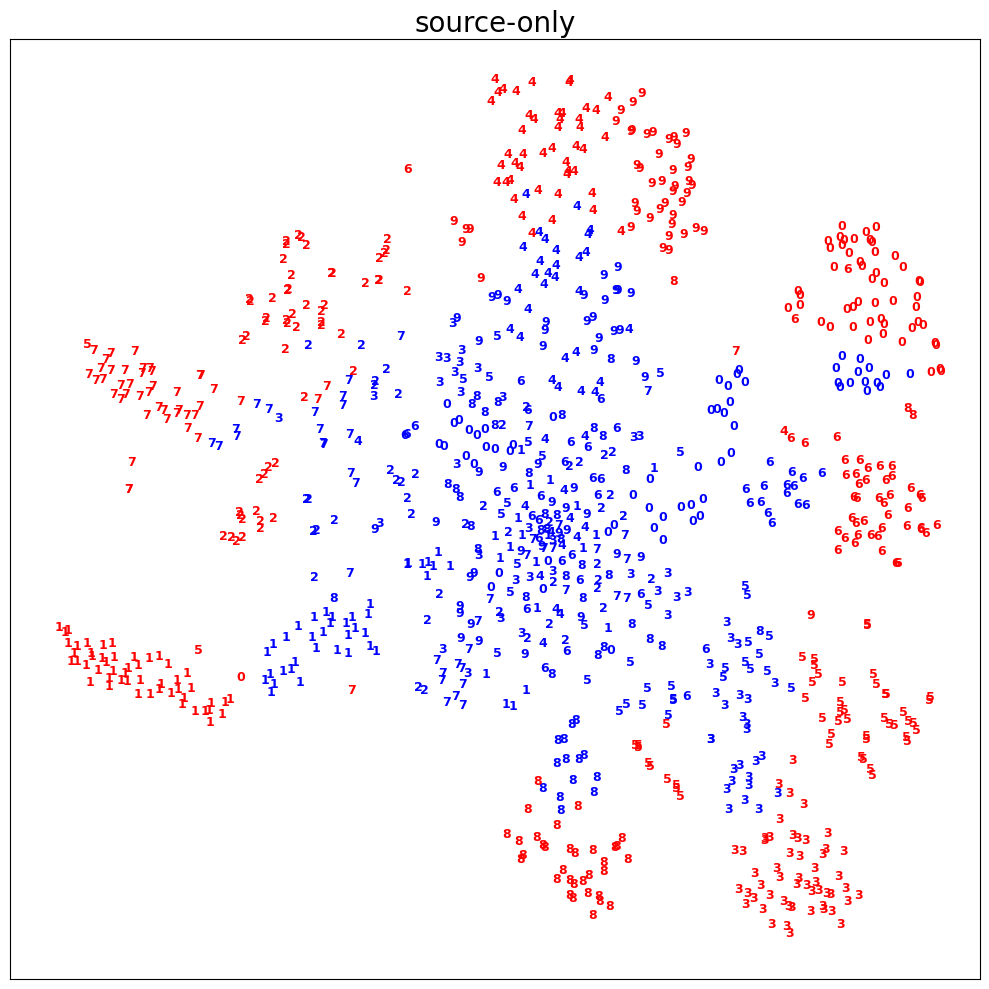

In [10]:
def main_source_only():
    """ The main function """

    # Get the dataloaders
    train_source_loader = get_mnist(cfg, train=True)
    train_target_loader = get_mnistm(cfg, train=True)
    test_source_loader = get_mnist(cfg, train=False)
    test_target_loader = get_mnistm(cfg, train=False)

    # Get the models
    extractor = Extractor(**cfg.model.extractor).cuda()
    classifier = Classifier(**cfg.model.classifier).cuda()
    discriminator = Discriminator(**cfg.model.discriminator).cuda()

    # Training
    extractor, classifier = source_only(extractor, classifier, train_source_loader, cfg)

    # Test
    print('\nTest Result with Source Datasets (MNIST)\n')
    test(extractor, classifier, test_source_loader)

    print('\nTest Result with Target Datasets (MNIST-M)\n')
    test(extractor, classifier, test_target_loader)

    # Visualization
    print('\nVisualizing...\n')
    visualize(extractor, test_source_loader, test_target_loader, 'source-only.png')

    print('Done!')


if __name__ == '__main__':
    main_source_only()

### DANN


DANN Training...

Epoch [   1/  50] Loss:   0.2196, Class Loss:   0.1721, Domain Loss:   0.0475, Accuracy:  94.69%, ETA: 0:31:55
Epoch [   2/  50] Loss:   0.2094, Class Loss:   0.0567, Domain Loss:   0.1527, Accuracy:  98.27%, ETA: 0:31:17
Epoch [   3/  50] Loss:   0.5462, Class Loss:   0.0604, Domain Loss:   0.4858, Accuracy:  98.13%, ETA: 0:30:44
Epoch [   4/  50] Loss:   0.5346, Class Loss:   0.0489, Domain Loss:   0.4857, Accuracy:  98.47%, ETA: 0:30:07
Epoch [   5/  50] Loss:   0.5789, Class Loss:   0.0455, Domain Loss:   0.5334, Accuracy:  98.55%, ETA: 0:29:22
Epoch [   6/  50] Loss:   0.6047, Class Loss:   0.0433, Domain Loss:   0.5614, Accuracy:  98.63%, ETA: 0:28:45
Epoch [   7/  50] Loss:   0.6242, Class Loss:   0.0401, Domain Loss:   0.5841, Accuracy:  98.69%, ETA: 0:28:08
Epoch [   8/  50] Loss:   0.6341, Class Loss:   0.0381, Domain Loss:   0.5960, Accuracy:  98.71%, ETA: 0:27:26
Epoch [   9/  50] Loss:   0.6370, Class Loss:   0.0366, Domain Loss:   0.6004, Accuracy:  98.

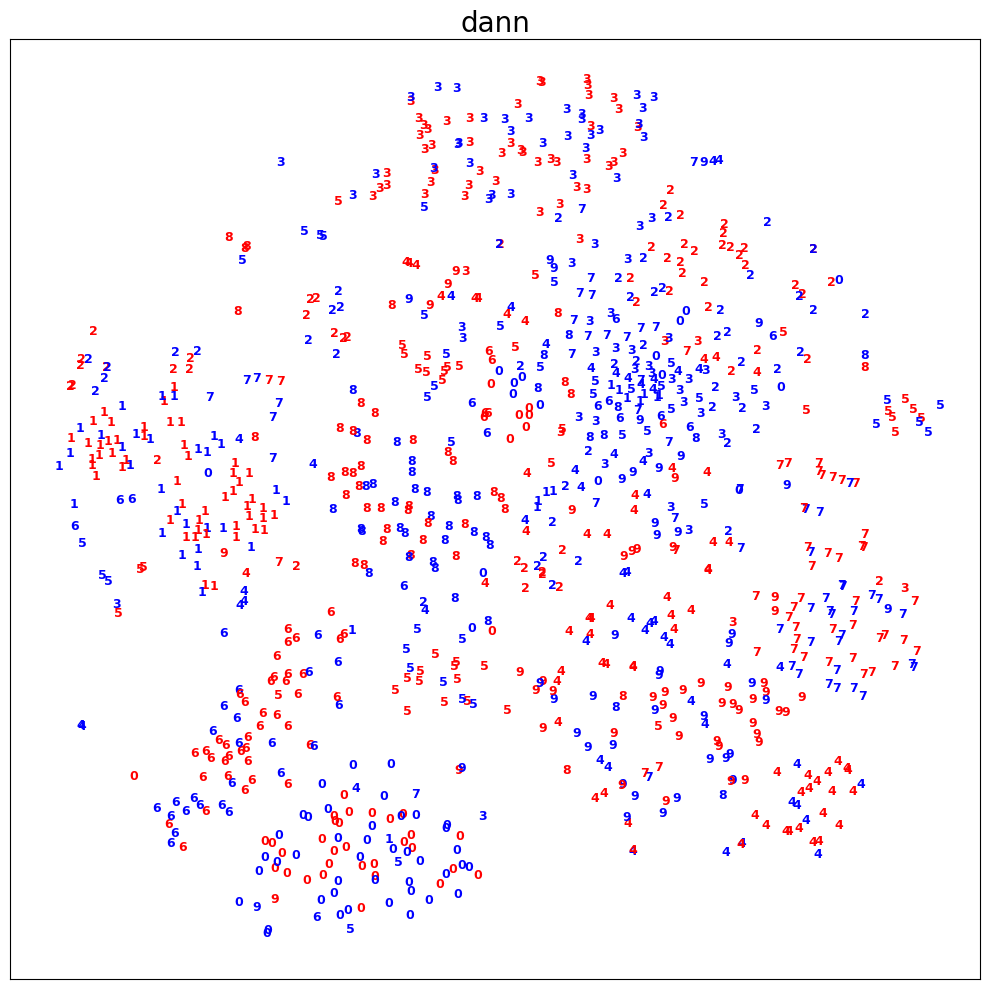

In [11]:
def main_dann():
    """ The main function """

    # Get the dataloaders
    train_source_loader = get_mnist(cfg, train=True)
    train_target_loader = get_mnistm(cfg, train=True)
    test_source_loader = get_mnist(cfg, train=False)
    test_target_loader = get_mnistm(cfg, train=False)

    # Get the models
    extractor = Extractor(**cfg.model.extractor).cuda()
    classifier = Classifier(**cfg.model.classifier).cuda()
    discriminator = Discriminator(**cfg.model.discriminator).cuda()

    # Training
    extractor, classifier = dann(extractor, classifier, discriminator, train_source_loader, train_target_loader, cfg)

    # Test
    print('\nTest Result with Source Datasets (MNIST)\n')
    test(extractor, classifier, test_source_loader)

    print('\nTest Result with Target Datasets (MNIST-M)\n')
    test(extractor, classifier, test_target_loader)

    # Visualization
    print('\nVisualizing...\n')
    visualize(extractor, test_source_loader, test_target_loader, 'dann.png')

    print('Done!')


if __name__ == '__main__':
    main_dann()